Notebook can be run non-interactively by:

```bash
# directory where data tfrecord files live
export DATA_DIR=
# directory where model and checkpoints should be saved
export MODEL_DIR=
jupyter nbconvert --to notebook --execute Train.ipynb --output=Trained.ipynb
```

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import tensorflow as tf

In [2]:
tf.__version__

'1.11.0'

### Serving

Serving function if exporting model

In [7]:
def _convert_input_img(img):
    # Decode bytes of image and transform to expected type and shape
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.expand_dims(img, axis=-1)
    return img

def serving_input_receiver_fn():
    """Input receiver expects a batched input of images"""

    # Define inputs from serving receiver
    inputs = { 
        'image': tf.placeholder(tf.uint8, shape=[None, 28, 28]) 
    }    
    
    # Define features passed to model_fn
    features = {
        'image': tf.map_fn(_convert_input_img, inputs['image'], dtype=tf.float32)
    }
    
    return tf.estimator.export.ServingInputReceiver(features, inputs)

In [ ]:
exporter = tf.estimator.LatestExporter('unet', serving_input_receiver_fn)

## Train

In [10]:
import model
import data

In [3]:
data_dir = os.environ.get('DATA_DIR', 'AerialImageDataset/train')
model_dir = os.environ.get('MODEL_DIR', 'run1/run1')

tf.gfile.MakeDirs(model_dir)

In [6]:
train_input_fn = lambda: data.make_dataset(os.path.join(data_dir, 'train-*.tfrecord'), batch_size=2, shuffle=False)
val_input_fn = lambda: data.make_dataset(os.path.join(data_dir, 'validation-0.tfrecord'), batch_size=2, shuffle=False)

config = tf.estimator.RunConfig(
    train_distribute=tf.contrib.distribute.MirroredStrategy())

estimator = tf.estimator.Estimator(
    model_fn=model.unet_model, 
    model_dir=model_dir,
    config=config,
    params={
        'learning_rate': 1e-4
    }
)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'run1/run1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.mirrored_strategy.MirroredStrategy object at 0x12f9b6b70>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12f9b6c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_

In [ ]:
train_spec = tf.estimator.TrainSpec(train_input_fn, max_steps=10000) #, hooks=[debug_hook])
eval_spec = tf.estimator.EvalSpec(val_input_fn, steps=20)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_num_ps_replicas': 0, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2ff4d4cd30>, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_is_chief': True, '_protocol': None, '_distribute_coordinator_mode': None, '_save_checkpoints_steps': None, '_device_fn': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None, '_evaluation_master': '', '_model_dir': 'gs://pontiml/inria/model/run1', '_tf_random_seed': None, '_train_distribute': <tensorflow.contrib.distribute.py

## Test

In [7]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
img = cv2.imread('/Users/ponti/OneDrive - Readify/projects/ausco/aerial/Mackay/EPSG3857_Date20171027_Lat-21.191869_Lon149.167866_Mpp0.075.jpg')

May get out of memory exception due to size of input and model. Adjust `fx` and `fy` appropriately higher until no longer occurs

In [9]:
img = cv2.resize(img, (0,0), fx=6, fy=6)

In [10]:
width, height, _ = img.shape

Max pooling operations require input shape to be divisible by 2 when we are going to concatenate them later in the unet model. Make sure the input image is divisible by 2^(num pool layers). In our model above, we have 4 so setting that here

In [11]:
num_max_pools = 4
divisible_by = 2**num_max_pools

Calculate how much padding we need to apply to the bottom and right to make our image dimensions appropriately divisible

In [12]:
pad_right = divisible_by * math.ceil(width / divisible_by) - width
pad_bottom = divisible_by * math.ceil(height / divisible_by) - height

In [13]:
padded_img = np.pad(img, ((0, pad_right), (0, pad_bottom), (0,0)), 'constant', constant_values=0).astype(np.float32)

In [ ]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={ 'image': np.array([padded_img]) },
    num_epochs=1,
    shuffle=False)

pred = estimator.predict(pred_input_fn)

pred = list(pred)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from run1/run1/model.ckpt-2136
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [1]:
labeled_pred = np.squeeze(pred[0]['classes'].astype(np.uint8))

NameError: name 'np' is not defined

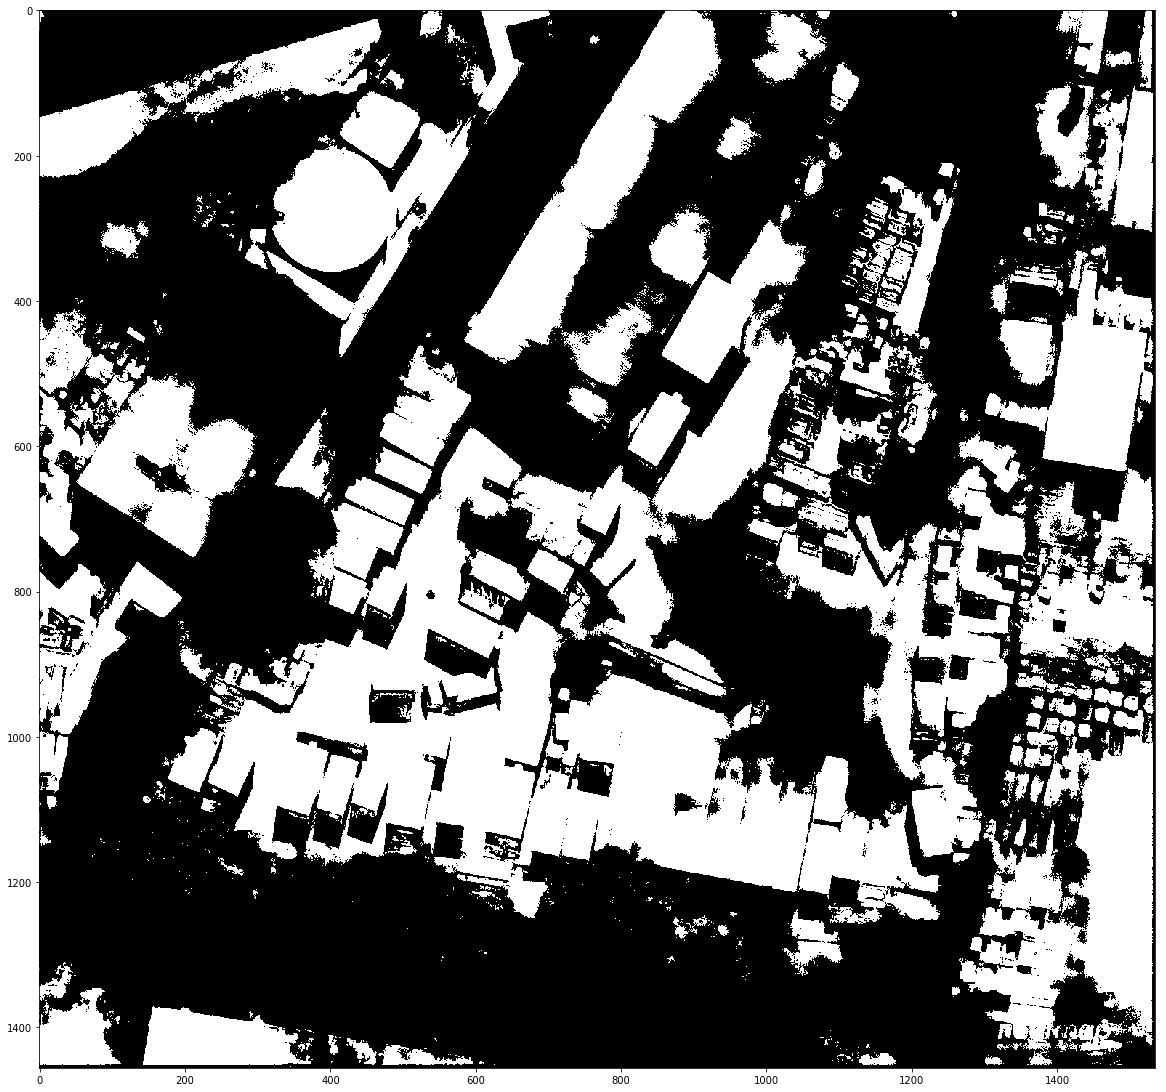

In [189]:
plt.figure(figsize=(20, 20))
plt.imshow(labeled_pred, cmap='gray')

In [190]:
result = np.zeros((512 * math.ceil(width / 512), 512 * math.ceil(height / 512)))

result_mask = np.repeat(np.expand_dims(labeled_pred, axis=-1), 3, axis=-1).astype(np.bool)

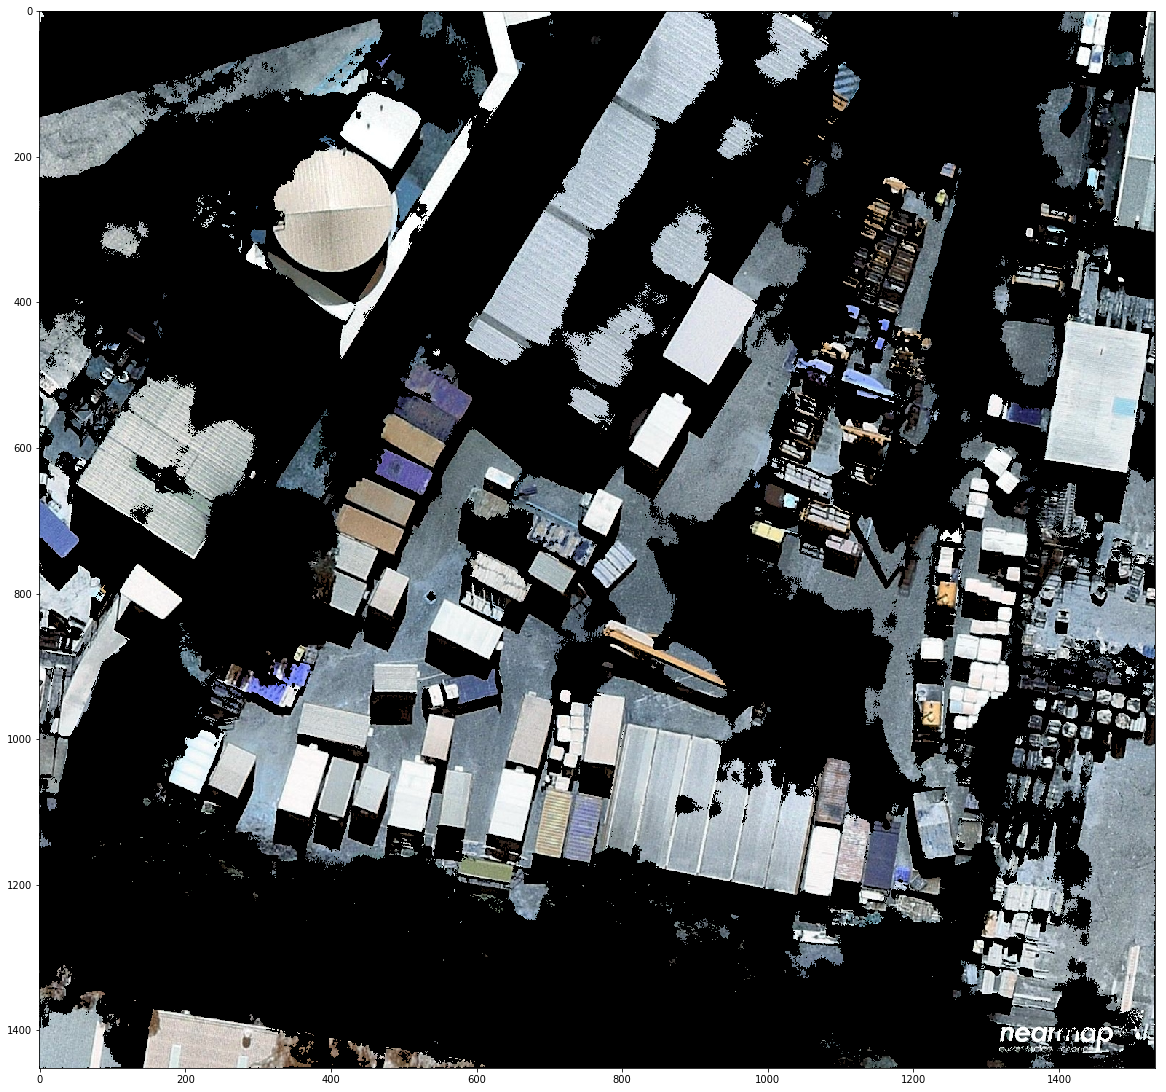

In [192]:
masked = np.where(result_mask[:width,:height], img, np.zeros(img.shape, dtype=np.uint8))

plt.figure(figsize=(20, 20))
plt.imshow(masked)